<a href="https://colab.research.google.com/github/sandipanpaul21/Logistic-regression-in-python/blob/main/13_LR_Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Regularization**

They work by penalizing (regularizing) the magnitude of coefficients of features along with minimizing the error between predicted and actual observations.

**Ridge (L2) and Lasso (L1) regression** 
- They are powerful techniques generally used for creating parsimonious models in presence of a ‘large’ number of features. 
- Here ‘large’ can typically mean either of two things:
  1. *Large enough to enhance the tendency of a model to overfit* (as low as 10 variables might cause overfitting)
  2. *Large enough to cause computational challenges.* With modern systems, this situation might arise in case of millions or billions of features

Though Ridge and Lasso might appear to work towards a common goal, the inherent properties and practical use cases differ substantially. 
- They work by penalizing the magnitude of coefficients of features along with minimizing the error between predicted and actual observations. 
- These are called **‘regularization’ techniques**. The key difference is in how they assign penalty to the coefficients:

**Ridge Regression:**

- Performs L2 regularization
- i.e. adds penalty equivalent to square of the magnitude of coefficients
  
    Minimization objective = LS Obj + α * (sum of square of coefficients)

**Lasso Regression:**
- Performs L1 regularization
- i.e. adds penalty equivalent to absolute value of the magnitude of coefficients

    Minimization objective = LS Obj + α * (sum of absolute value of coefficients)

**Note** that here ‘LS Obj’ refers to ‘least squares objective’, i.e. the linear regression objective without regularization.
 
**Why Penalize the Magnitude of Coefficients?**

Lets try to understand the impact of model complexity on the magnitude of coefficients. 

As an example, I have simulated a sine curve (between 60° and 300°) and added some random noise:

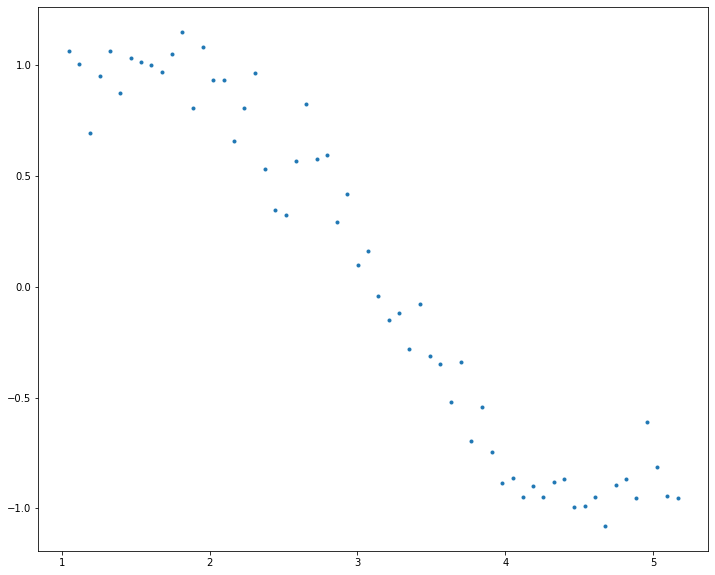

In [1]:
# Importing libraries

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 10

#Define input array with angles from 60deg to 300deg converted to radians
x = np.array([i*np.pi/180 for i in range(60,300,4)])
np.random.seed(10)  #Setting seed for reproducibility
y = np.sin(x) + np.random.normal(0,0.15,len(x))
data = pd.DataFrame(np.column_stack([x,y]),columns=['x','y'])
plt.plot(data['x'],data['y'],'.')

This resembles a sine curve but not exactly because of the noise. 

Let’s try to estimate the sine function using polynomial regression with powers of x from 1 to 15. 

Let’s add a column for each power upto 15 in our dataframe. 

In [2]:
for i in range(2,16):  #power of 1 is already there
    colname = 'x_%d'%i      #new var will be x_power
    data[colname] = data['x']**i
print(data.head())

          x         y       x_2  ...       x_13       x_14       x_15
0  1.047198  1.065763  1.096623  ...   1.821260   1.907219   1.997235
1  1.117011  1.006086  1.247713  ...   4.214494   4.707635   5.258479
2  1.186824  0.695374  1.408551  ...   9.268760  11.000386  13.055521
3  1.256637  0.949799  1.579137  ...  19.486248  24.487142  30.771450
4  1.326450  1.063496  1.759470  ...  39.353420  52.200353  69.241170

[5 rows x 16 columns]


Now that we have all the 15 powers, let’s make 15 different linear regression models with each model containing variables with powers of x from 1 to the particular model number. For example, the feature set of model 8 will be – {x, x_2, x_3, … ,x_8}.

First, we’ll define a generic function which takes in the required maximum power of x as an input and returns a list containing – [ model RSS, intercept, coef_x, coef_x2, … upto entered power ]. 

Here RSS refers to ‘Residual Sum of Squares’ which is nothing but the sum of square of errors between the predicted and actual values in the training data set.

Note that this function will not plot the model fit for all the powers but will return the RSS and coefficients for all the models. 

Now, we can make all 15 models and compare the results. For ease of analysis, we’ll store all the results in a Pandas dataframe and plot 6 models to get an idea of the trend. 

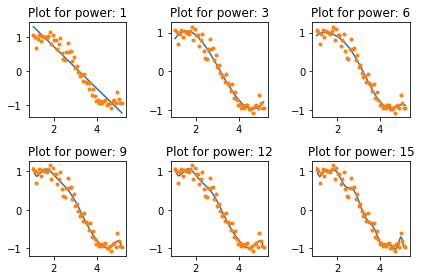

In [3]:
#Import Linear Regression model from scikit-learn.
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")
def linear_regression(data, power, models_to_plot):
    #initialize predictors:
    predictors=['x']
    if power>=2:
        predictors.extend(['x_%d'%i for i in range(2,power+1)])
    
    #Fit the model
    linreg = LinearRegression(normalize=True)
    linreg.fit(data[predictors],data['y'])
    y_pred = linreg.predict(data[predictors])
    
    #Check if a plot is to be made for the entered power
    if power in models_to_plot:
        plt.subplot(models_to_plot[power])
        plt.tight_layout()
        plt.plot(data['x'],y_pred)
        plt.plot(data['x'],data['y'],'.')
        plt.title('Plot for power: %d'%power)
    
    #Return the result in pre-defined format
    rss = sum((y_pred-data['y'])**2)
    ret = [rss]
    ret.extend([linreg.intercept_])
    ret.extend(linreg.coef_)
    return ret

#Initialize a dataframe to store the results:
col = ['rss','intercept'] + ['coef_x_%d'%i for i in range(1,16)]
ind = ['model_pow_%d'%i for i in range(1,16)]
coef_matrix_simple = pd.DataFrame(index=ind, columns=col)

#Define the powers for which a plot is required:
models_to_plot = {1:231,3:232,6:233,9:234,12:235,15:236}

#Iterate through all powers and assimilate results
for i in range(1,16):
    coef_matrix_simple.iloc[i-1,0:i+2] = linear_regression(data, power=i, models_to_plot=models_to_plot)

We would expect the models with increasing complexity to better fit the data and result in lower RSS values. This can be verified by looking at the plots generated for 6 models.

This clearly aligns with our initial understanding. As the model complexity increases, the models tends to fit even smaller deviations in the training data set. Though this **leads to overfitting**, lets keep this issue aside for some time and come to our main objective, i.e. the impact on the magnitude of coefficients.



In [5]:
#Set the display format to be scientific for ease of analysis
pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_simple

,rss,intercept,coef_x_1,coef_x_2,coef_x_3,coef_x_4,coef_x_5,coef_x_6,coef_x_7,coef_x_8,coef_x_9,coef_x_10,coef_x_11,coef_x_12,coef_x_13,coef_x_14,coef_x_15
model_pow_1,3.3,2,-0.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_2,3.3,1.9,-0.58,-0.006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_3,1.1,-1.1,3,-1.3,0.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_4,1.1,-0.27,1.7,-0.53,-0.036,0.014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_5,1,3,-5.1,4.7,-1.9,0.33,-0.021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_6,0.99,-2.8,9.5,-9.7,5.2,-1.6,0.23,-0.014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_7,0.93,19,-56,69,-45,17,-3.5,0.4,-0.019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_8,0.92,43,-1.4e+02,1.8e+02,-1.3e+02,58,-15,2.4,-0.21,0.0077,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_9,0.87,1.7e+02,-6.1e+02,9.6e+02,-8.5e+02,4.6e+02,-1.6e+02,37,-5.2,0.42,-0.015,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_10,0.87,1.4e+02,-4.9e+02,7.3e+02,-6e+02,2.9e+02,-87,15,-0.81,-0.14,0.026,-0.0013,NaN,NaN,NaN,NaN,NaN


It is clearly evident that the size of coefficients increase exponentially with increase in model complexity. Compare Power 2 with Power 15 Coefficients.

**What does a large coefficient signify?(Power 2 or 3 or 4)**

- It means that we’re putting a lot of emphasis on that feature, i.e. the particular feature is a good predictor for the outcome. 
- When it becomes too large, the algorithm starts modelling intricate relations to estimate the output and ends up overfitting to the particular training data.